1. Users in test? 107068

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"daleschyov","key":"92e659c9a4dcaabcaa13ce84697c8e9a"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c test-recsys

tab_2_products_2020-08-18.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
tab_2_products_2020-09-07.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
tab_2_products_2020-08-08.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
tab_2_products_2020-08-28.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
tab_2_products_2020-06-29.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
tab_2_products_2020-06-09.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
tab_2_products_2020-06-19.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
tab_2_products_2020-07-19.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
tab_2_products_2020-07-29.csv.zip: Skipping, found more recently

In [4]:
from zipfile import ZipFile

file_name = "sample_submission.csv.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
DATA_PATH = "data"

In [6]:
# Imports
import pandas as pd
import numpy as np
import datetime 
from pathlib import Path
from tqdm.notebook import tqdm
import os

%matplotlib inline 

In [7]:
submission_df = pd.read_csv( "sample_submission.csv")
test_user_ids = submission_df.Id
print("Unique test users:", test_user_ids.nunique())
submission_df.head(3)

Unique test users: 107068


,Id,Predicted
0,51,3239211 10720024 8493844 1965540 5009002 95218...
1,65,11693356 13392267 2464515 2245175 4748570 1134...
2,766,12773054 3692749 12726751 10041624 11893515 23...


In [8]:
def replace_date(date_str):
    if len(date_str) < 8:
        return '2020-10-09'
    else:
        return date_str

def str2date(date_str):
    try:
        date = datetime.datetime.strptime(date_str, '%Y-%m-%d')
    except:
        date = datetime.datetime.strptime(date_str, '%d.%m.%Y')
    return date

def calculate_age(born):
    today = datetime.date.today()
    age = today.year - born.year - ((today.month, today.day) < (born.month, born.day))
    if age < 10 or age > 70:
        age = 0
    return age

In [9]:
from zipfile import ZipFile

file_name = "tab_4_user_profiles.csv.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [10]:
## Preprocess Users
user_df = pd.read_csv("tab_4_user_profiles.csv")

uniq = user_df.user_id.nunique()
print(
    f"Users in original file {len(user_df)}, unique {uniq}, diff {len(user_df) - uniq}")

# Filter users not in test
user_df = user_df[user_df.user_id.isin(test_user_ids)]
uniq = user_df.user_id.nunique()
print(f"After filtering {len(user_df)}, unique {uniq}, diff {len(user_df) - uniq}")

# Drop duplicates (352 / ~2% of the data)
user_df.drop_duplicates("user_id", inplace=True)

# Drop NaNs
user_df.dropna(inplace=True)
uniq = user_df.user_id.nunique()
print(f"After droping duplicates and NaN's {len(user_df)}, unique {uniq}, diff {len(user_df) - uniq}")


# Replace incorrect dates
user_df.bdate = user_df.bdate.map(lambda x: replace_date(x))
# Convert all dates to datetime object
user_df.bdate = user_df.bdate.map(lambda x: str2date(x))
# Add new column with age
user_df["age"] = user_df.bdate.map(lambda x: calculate_age(x))
# Drop bdate column
user_df.drop(columns="bdate", inplace=True)
# Label code column
user_df.gender = user_df.gender.astype('category').cat.codes

print(f"Sanity check. Should be same as previous {len(user_df)}, unique {uniq}, diff {len(user_df) - uniq}")
user_df.head()

Users in original file 438867, unique 436927, diff 1940
After filtering 20764, unique 20412, diff 352
After droping duplicates and NaN's 8254, unique 8254, diff 0
Sanity check. Should be same as previous 8254, unique 8254, diff 0


,user_id,gender,age
10,1288925,1,38
43,1780454,0,0
48,534410,0,29
73,1050790,0,33
85,2119485,0,28


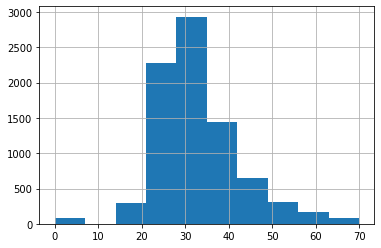

In [11]:
user_df.age.hist()

In [12]:
## Preprocess Citys
city_df = pd.read_csv( "tab_6_city.csv")
city_df.city_name = city_df.city_name.astype('category').cat.codes
city_df.head(3)

,store_id,city_name
0,14,45
1,21,45
2,1,45


In [13]:
from zipfile import ZipFile

file_name = "tab_1_orders.csv.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [14]:
# diff is because correct primary key is [order_id, store_id]

## Preprocess Orders
orders_df = pd.read_csv("tab_1_orders.csv")
uniq = orders_df.order_id.nunique()
print(f"Rows in original file {len(orders_df)}, unique {uniq}, diff {len(orders_df) - uniq}")
# Filter orders only from test users
orders_df = orders_df[orders_df.user_id.isin(test_user_ids)]
uniq = orders_df.order_id.nunique()
print(f"After filtering {len(orders_df)}, unique {uniq}, diff {len(orders_df) - uniq}")

# Drop duplicates
orders_df.drop_duplicates(["order_id", "store_id"], inplace=True)
uniq = orders_df.order_id.nunique()
print(f"After dropping duplicates {len(orders_df)}, unique {uniq}, diff {len(orders_df) - uniq}")

# Label code columns
orders_df.retailer = orders_df.retailer.astype('category').cat.codes
orders_df.platform = orders_df.platform.astype('category').cat.codes

# Merge city data
orders_df = orders_df.set_index('store_id').join(city_df.set_index('store_id'))
orders_df.reset_index(inplace=True)
# # Merge user data
orders_df = orders_df.set_index('user_id').join(user_df.set_index('user_id'))
orders_df.reset_index(inplace=True)

uniq = orders_df.order_id.nunique()
print(f"Sanity check. Should be same as previous {len(orders_df)}, unique {uniq}, diff {len(orders_df) - uniq}")
orders_df.head()

Rows in original file 2461958, unique 2426955, diff 35003
After filtering 967345, unique 953436, diff 13909
After dropping duplicates 967340, unique 953436, diff 13904
Sanity check. Should be same as previous 967340, unique 953436, diff 13904


,user_id,store_id,order_id,order_created_time,retailer,platform,city_name,gender,age
0,187,533,15952443,2020-09-01 17:34:00,16,0,45,NaN,NaN
1,400,11,11911561,2020-06-13 13:26:03,2,0,45,NaN,NaN
2,400,11,11922112,2020-06-13 16:30:57,2,0,45,NaN,NaN
3,400,11,12264981,2020-06-19 11:57:25,2,0,45,NaN,NaN
4,400,11,12749996,2020-06-29 19:14:42,2,0,45,NaN,NaN


In [15]:
# Add new feature
orders_df['order_created_time'] = pd.to_datetime(orders_df['order_created_time'])
tmp = orders_df.drop_duplicates(["order_id"]).sort_values(by=["user_id", "order_id", "order_created_time"])
tmp['day_since_prior_order'] = tmp.groupby(['user_id'])['order_created_time'].diff().dt.days.fillna(-1)
orders_df = orders_df.merge(tmp[["order_id", "day_since_prior_order"]])

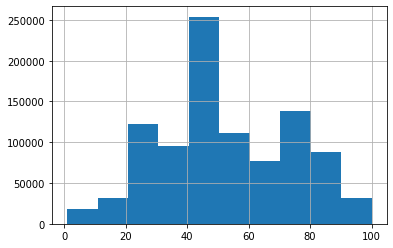

In [16]:
orders_df.city_name.hist()

In [17]:
## Preprocess Products
import os, fnmatch
pathes = sorted(fnmatch.filter(os.listdir('.'), 'tab_2*'))
dfs = []

for path in tqdm(pathes):
    # Read DF
    df = pd.read_csv(path)
    
    # Filter and delete users not from test
    df = df[df.user_id.isin(test_user_ids)]

    # Drop column with long desciption
    df.drop(columns=["product_name"], inplace=True)
    
    # Label code column
    df.brand_name = df.brand_name.astype('category').cat.codes
    
    # Fill NaNs in one column
    df.master_category_id.fillna(-1, inplace=True)
    dfs.append(df)

In [18]:
products_df = pd.concat(dfs)
print("Num rows in filtered products:", len(products_df)) # 21677070
print("Num unique products:", products_df.product_id.nunique()) # 91994

Num rows in filtered products: 21677070
Num unique products: 91994


In [19]:
# Compare `orders_id`
orders_from_orders = set(orders_df.order_id)
orders_from_products = set(products_df.order_id)
print(f"Orders: {len(orders_from_orders)}, Products: {len(orders_from_products)}")
print(f"Intersection: {len(orders_from_orders.intersection(orders_from_products))}")
print(f"Union orders: {len(orders_from_orders.difference(orders_from_products))}")
print(f"Union products: {len(orders_from_products.difference(orders_from_orders))}")

# Not for all users/orders in Products table we can find corresponding element in Orders to get additional features

Orders: 953436, Products: 839874
Intersection: 792285
Union orders: 161151
Union products: 47589


In [20]:
# Mean order size per user
mean_orders = (products_df.groupby(["user_id", "order_id"])
                         .agg({'line_item_id':'count'})
                         .groupby("user_id").mean()
                         .rename(columns={'line_item_id':'mean_order_size'}))

products_df = products_df.merge(mean_orders, on='user_id')

In [21]:
# Merge Orders data
tmp = orders_df.drop_duplicates("order_id").drop(columns="user_id")
products_df = products_df.merge(tmp, how='left', on='order_id')
products_df.head()

,user_id,order_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,mean_order_size,store_id,order_created_time,retailer,platform,city_name,gender,age,day_since_prior_order
0,766,5395508,28998751,24.270000,3,0.000000,3069043,2260,77.0,74,19.217391,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,766,5395508,28998796,79.300003,3,0.000000,3041849,1856,26.0,20,19.217391,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,766,5395508,28999083,76.620003,5,15.070000,216,1375,607.0,20,19.217391,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,766,5395508,28999153,72.180000,1,19.540001,1990,1292,32.0,20,19.217391,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,766,5395508,28999278,142.500000,3,0.000000,3883053,1397,31.0,20,19.217391,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
len(products_df)

21677070

## Convert products df into training data for logistic regression

In [23]:
#     # Change data types to reduce memory footprint
#     df.astype({
#         'user_id': 'int32',
#         'order_id': 'int32',
#         'price': 'float32',
#         'quantity': 'int32',
#         'discount': 'float32',
#         'product_id': 'int32',
#         'brand_name': 'int32',
#         'master_category_id': 'int32',
#         'parent_category_id': 'int32'}, copy=False)

In [38]:
ids = products_df.groupby('user_id').order_id.count().sort_values(ascending = False)[:1000].keys()

['age',
 'day_since_prior_order',
 'user_id',
 'store_id',
 'gender',
 'order_id',
 'platform',
 'city_name',
 'order_created_time',
 'retailer']

In [105]:
# Can be slow, just wait =)

merged_df = products_df[products_df.user_id.isin(ids)].merge(orders_df[orders_df.user_id.isin(ids)], 
                                                             on = list(set(orders_df.columns).intersection(products_df.columns)))
merged_df.reset_index(inplace=True)
print("Total:", len(merged_df))

Total: 1354723


In [106]:
merged_df.head()

,index,user_id,order_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,mean_order_size,store_id,order_created_time,retailer,platform,city_name,gender,age,day_since_prior_order
0,0,13311,5581075,29870834,64.989998,1,40.02,22107,313,596.0,51,32.615385,2.0,2020-01-05 15:23:53,2.0,2.0,45.0,NaN,NaN,-1.0
1,1,13311,5581075,29870889,125.000000,3,0.00,7397,1362,223.0,221,32.615385,2.0,2020-01-05 15:23:53,2.0,2.0,45.0,NaN,NaN,-1.0
2,2,13311,5581075,29870901,262.100006,1,0.00,4785,1896,49.0,42,32.615385,2.0,2020-01-05 15:23:53,2.0,2.0,45.0,NaN,NaN,-1.0
3,3,13311,5581075,29870957,329.000000,2,371.00,6766,218,128.0,126,32.615385,2.0,2020-01-05 15:23:53,2.0,2.0,45.0,NaN,NaN,-1.0
4,4,13311,5581075,29870967,196.000000,1,0.00,7518,926,217.0,216,32.615385,2.0,2020-01-05 15:23:53,2.0,2.0,45.0,NaN,NaN,-1.0


In [107]:
merged_df.fillna(value=-1, inplace=True)

In [108]:
merged_df.columns

last_order_date = merged_df.groupby('user_id').order_created_time.max()

merged_df['last_order_date'] = merged_df.user_id.map(last_order_date)

validate =  merged_df[merged_df.last_order_date == merged_df.order_created_time]
train = merged_df[merged_df.last_order_date != merged_df.order_created_time]

last_order_date = train.groupby('user_id').order_created_time.max()
train['last_order_date'] = train.user_id.map(last_order_date)

Index(['index', 'user_id', 'order_id', 'line_item_id', 'price', 'quantity',
       'discount', 'product_id', 'brand_name', 'master_category_id',
       'parent_category_id', 'mean_order_size', 'store_id',
       'order_created_time', 'retailer', 'platform', 'city_name', 'gender',
       'age', 'day_since_prior_order'],
      dtype='object')

In [73]:
 products_df.head()

,user_id,order_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,mean_order_size,store_id,order_created_time,retailer,platform,city_name,gender,age,day_since_prior_order
0,766,5395508,28998751,24.270000,3,0.000000,3069043,2260,77.0,74,19.217391,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,766,5395508,28998796,79.300003,3,0.000000,3041849,1856,26.0,20,19.217391,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,766,5395508,28999083,76.620003,5,15.070000,216,1375,607.0,20,19.217391,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,766,5395508,28999153,72.180000,1,19.540001,1990,1292,32.0,20,19.217391,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,766,5395508,28999278,142.500000,3,0.000000,3883053,1397,31.0,20,19.217391,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Change data types to reduce memory footprint
merged_df = merged_df.astype({
    'user_id': 'int32',
    'order_id': 'int32',
    'price': 'float32',
    'quantity': 'int32',
    'discount': 'float32',
    'product_id': 'int32',
    'brand_name': 'int32',
    'master_category_id': 'int32',
    'parent_category_id': 'int32',
    'retailer': 'int16',
    'platform': 'int8',
    'city_name': 'int16',
    'gender': 'int8',
    'age': 'int8',
    }, copy=True)

"# Change data types to reduce memory footprint\nmerged_df = merged_df.astype({\n    'user_id': 'int32',\n    'order_id': 'int32',\n    'price': 'float32',\n    'quantity': 'int32',\n    'discount': 'float32',\n    'product_id': 'int32',\n    'brand_name': 'int32',\n    'master_category_id': 'int32',\n    'parent_category_id': 'int32',\n    'retailer': 'int16',\n    'platform': 'int8',\n    'city_name': 'int16',\n    'gender': 'int8',\n    'age': 'int8',\n    }, copy=True)"

In [ ]:
merged_df.dtypes

In [ ]:
merged_df.head()

In [ ]:
merged_df.to_csv(os.path.join(DATA_PATH, "merged_data.csv"))

In [ ]:
merged_df.product_id.value_counts()

In [ ]:
merged_df['count'] = 1
df_agg = merged_df.groupby(["user_id", "product_id"]).agg({'count':sum})
g = df_agg['count'].groupby(level=0, group_keys=False)

In [ ]:
res = g.nlargest(50)
res.reset_index(inplace=True)
res.product_id = res.product_id.astype('str')
submit = res.groupby('user_id')['product_id'].apply(' '.join).reset_index()
submit.columns = ["Id", "Predicted"]
submit.to_csv("my_sumbit1.csv", index=False)